In [56]:
import numpy as np
import scipy, h5py
import scipy.stats as stats
import os,sys
import tables
import scipy.io as scio
import matplotlib.pyplot as plt
import uproot, argparse
from scipy.optimize import minimize
from scipy import interpolate
from numpy.polynomial import legendre as LG
from scipy import special
import warnings

In [57]:
warnings.filterwarnings('ignore')

h = tables.open_file('../../calib/Time_coeff_1t.h5','r')
coeff = h.root.coeff[:]
h.close()
cut, fitcut = coeff.shape

# physical constant
Light_yield = 4285*0.88 # light yield
Att_LS = 18 # attenuation length of LS
Att_Wtr = 300 # attenuation length of water
tau_r = 1.6 # fast time constant
TTS = 5.5/2.355
QE = 0.20
PMT_radius = 0.254
c = 2.99792e8
n = 1.48
shell = 0.6 # Acrylic

In [82]:
def Likelihood_flight(vertex, *args):
    coeff, PMT_pos, fired, time, cut = args
    y = time - vertex[0]
    dist = np.sqrt(np.sum((PMT_pos[fired] - vertex[1:4])**2, axis=1))
    flight_time = dist/(c/n)*1e9
    L = - np.nansum(TimeProfile_flight(y, flight_time))
    return L

def TimeProfile_flight(y,T_i):
    time_correct = y - T_i
    time_correct[time_correct<=-8] = -8
    p_time = TimeUncertainty(time_correct, 26)
    return p_time

def TimeUncertainty(tc, tau_d):
    TTS = 2.2
    tau_r = 1.6
    a1 = np.exp(((TTS**2 - tc*tau_d)**2-tc**2*tau_d**2)/(2*TTS**2*tau_d**2))
    a2 = np.exp(((TTS**2*(tau_d+tau_r) - tc*tau_d*tau_r)**2 - tc**2*tau_d**2*tau_r**2)/(2*TTS**2*tau_d**2*tau_r**2))
    a3 = np.exp(((TTS**2 - tc*tau_d)**2 - tc**2*tau_d**2)/(2*TTS**2*tau_d**2))*special.erf((tc*tau_d-TTS**2)/(np.sqrt(2)*tau_d*TTS))
    a4 = np.exp(((TTS**2*(tau_d+tau_r) - tc*tau_d*tau_r)**2 - tc**2*tau_d**2*tau_r**2)/(2*TTS**2*tau_d**2*tau_r**2))*special.erf((tc*tau_d*tau_r-TTS**2*(tau_d+tau_r))/(np.sqrt(2)*tau_d*tau_r*TTS))
    p_time  = np.log(tau_d + tau_r) - 2*np.log(tau_d) + np.log(a1-a2+a3-a4)
    return p_time

In [83]:
def Likelihood_fit(vertex, *args):
    coeff, PMT_pos, fired, time, cut = args
    y = time
    # fixed axis
    z = np.sqrt(np.sum(vertex[1:4]**2))/shell
    cos_theta = np.sum(vertex[1:4]*PMT_pos,axis=1)\
        /np.sqrt(np.sum(vertex[1:4]**2)*np.sum(PMT_pos**2,axis=1))
    # accurancy and nan value
    cos_theta = np.nan_to_num(cos_theta)
    cos_theta[cos_theta>1] = 1
    cos_theta[cos_theta<-1] =-1

    cos_total = cos_theta[fired]
    
    size = np.size(cos_total)
    x = np.zeros((size, cut))
    # legendre coeff
    for i in np.arange(0,cut):
        c = np.zeros(cut)
        c[i] = 1
        x[:,i] = LG.legval(cos_total,c)

    k = np.zeros((1,cut))
    for i in np.arange(cut):
        # cubic interp
        k[0,i] = np.sum(np.polynomial.legendre.legval(z,coeff[i,:]))
    #k[0,1] = k[0,1] /14.4*0.8/3
    #k[0,2:4] = k[0,2:4] /14.4*0.8*3
    #k[0] = k[0] + np.log(vertex[0])
    k[0,0] = vertex[0]
    
    T_i = np.dot(x, np.transpose(k))
    L = Likelihood_quantile(y, T_i[:,0], 0.1, 0.3)
    # L = - np.nansum(TimeProfile_fit(y, T_i[:,0]))
    # print('%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.0f' % (k[0,1], k[0,2], k[0,3], k[0,4] ,z, L))
    return L

def Likelihood_quantile(y, T_i, tau, ts):
    less = T_i[y<T_i] - y[y<T_i]
    more = y[y>=T_i] - T_i[y>=T_i]

    R = (1-tau)*np.sum(less) + tau*np.sum(more)
    #log_Likelihood = exp
    return R

def TimeProfile_fit(y,T_i):
    time_correct = y - T_i
    time_correct[time_correct<=-8] = -8
    p_time = TimeUncertainty_fit(time_correct, 10)
    return p_time

def TimeUncertainty_fit(tc, tau_d):
    TTS = 2.2
    tau_r = 1.6
    a1 = np.exp(((TTS**2 - tc*tau_d)**2-tc**2*tau_d**2)/(2*TTS**2*tau_d**2))
    a2 = np.exp(((TTS**2*(tau_d+tau_r) - tc*tau_d*tau_r)**2 - tc**2*tau_d**2*tau_r**2)/(2*TTS**2*tau_d**2*tau_r**2))
    a3 = np.exp(((TTS**2 - tc*tau_d)**2 - tc**2*tau_d**2)/(2*TTS**2*tau_d**2))*special.erf((tc*tau_d-TTS**2)/(np.sqrt(2)*tau_d*TTS))
    a4 = np.exp(((TTS**2*(tau_d+tau_r) - tc*tau_d*tau_r)**2 - tc**2*tau_d**2*tau_r**2)/(2*TTS**2*tau_d**2*tau_r**2))*special.erf((tc*tau_d*tau_r-TTS**2*(tau_d+tau_r))/(np.sqrt(2)*tau_d*tau_r*TTS))
    p_time  = np.log(tau_d + tau_r) - 2*np.log(tau_d) + np.log(a1-a2+a3-a4)
    return p_time

In [84]:
def Likelihood_Time(vertex, *args):
    coeff, PMT_pos, fired, time, cut = args
    y = time - vertex[0]
    # fixed axis
    z = np.sqrt(np.sum(vertex[1:4]**2))/shell
    cos_theta = np.sum(vertex[1:4]*PMT_pos,axis=1)\
        /np.sqrt(np.sum(vertex[1:4]**2)*np.sum(PMT_pos**2,axis=1))
    # accurancy and nan value
    cos_theta = np.nan_to_num(cos_theta)
    cos_theta[cos_theta>1] = 1
    cos_theta[cos_theta<-1] =-1

    cos_total = cos_theta[fired]
    
    size = np.size(cos_total)
    x = np.zeros((size, cut))
    # legendre coeff
    for i in np.arange(0,cut):
        c = np.zeros(cut)
        c[i] = 1
        x[:,i] = LG.legval(cos_total,c)

    k = np.zeros((1,cut))
    for i in np.arange(cut):
        # cubic interp
        k[0,i] = np.sum(np.polynomial.legendre.legval(z,coeff[i,:]))
    
    #k[0] = k[0] + np.log(vertex[0])
    k[0,0] = vertex[0]
    T_i = np.dot(x, np.transpose(k))
    #L = Likelihood_quantile(y, T_i[:,0], 0.01, 0.3)
    L = - np.nansum(TimeProfile1(y, T_i[:,0]))
    return L, y - T_i[:,0]

def Likelihood_quantile(y, T_i, tau, ts):
    less = T_i[y<T_i] - y[y<T_i]
    more = y[y>=T_i] - T_i[y>=T_i]

    R = (1-tau)*np.sum(less) + tau*np.sum(more)
    #log_Likelihood = exp
    return R

def TimeProfile1(y,T_i):
    time_correct = y - T_i
    #time_correct[time_correct<=-8] = -8
    plt.hist(time_correct, bins=100)
    p_time = TimeUncertainty1(time_correct, 26)
    return p_time

def TimeUncertainty1(tc, tau_d):
    TTS = 2.2
    tau_r = 1.6
    a1 = np.exp(((TTS**2 - tc*tau_d)**2-tc**2*tau_d**2)/(2*TTS**2*tau_d**2))
    a2 = np.exp(((TTS**2*(tau_d+tau_r) - tc*tau_d*tau_r)**2 - tc**2*tau_d**2*tau_r**2)/(2*TTS**2*tau_d**2*tau_r**2))
    a3 = np.exp(((TTS**2 - tc*tau_d)**2 - tc**2*tau_d**2)/(2*TTS**2*tau_d**2))*special.erf((tc*tau_d-TTS**2)/(np.sqrt(2)*tau_d*TTS))
    a4 = np.exp(((TTS**2*(tau_d+tau_r) - tc*tau_d*tau_r)**2 - tc**2*tau_d**2*tau_r**2)/(2*TTS**2*tau_d**2*tau_r**2))*special.erf((tc*tau_d*tau_r-TTS**2*(tau_d+tau_r))/(np.sqrt(2)*tau_d*tau_r*TTS))
    p_time  = np.log(tau_d + tau_r) - 2*np.log(tau_d) + np.log(a1-a2+a3-a4)
    return p_time

In [85]:
def con_sph(args):
    E_min,\
    E_max,\
    tau_min,\
    tau_max,\
    t0_min,\
    t0_max\
    = args
    cons = ({'type': 'ineq', 'fun': lambda x: shell**2 - (x[1]**2 + x[2]**2 + x[3]**2)})
    return cons

In [86]:
def ReadPMT():
    f = open(r"../PMT_1t.txt")
    line = f.readline()
    data_list = [] 
    while line:
        num = list(map(float,line.split()))
        data_list.append(num)
        line = f.readline()
    f.close()
    PMT_pos = np.array(data_list)
    PMT_pos = PMT_pos
    return PMT_pos

In [97]:
def main(event_count):
    PMT_pos = ReadPMT()
    fid = '/mnt/stage/douwei/Simulation/1t_root/1MeV_1_h5/1t_+0.30.h5'
    # Loop for event

    h = tables.open_file(fid,'r')
    rawdata = h.root.GroundTruth
    EventID = rawdata[:]['EventID']
    ChannelID = rawdata[:]['ChannelID']
    Time = rawdata[:]['PETime']
    h.close()
    index = (np.abs(EventID - event_count)<1e-3)
    pe_array = np.zeros(np.size(PMT_pos[:,1])) # Photons on each PMT (PMT size * 1 vector)
    fired_PMT = ChannelID[index]
    for j in np.arange(np.size(fired_PMT)):
        pe_array[fired_PMT[j]] = pe_array[fired_PMT[j]]+1

    fired_PMT = fired_PMT.astype(int)        
    time_array = Time[index]

    # filter
    index_1 = (time_array>np.mean(time_array)-100) & (time_array < np.mean(time_array)+100)
    time_array = time_array[index_1]
    fired_PMT = fired_PMT[index_1]

    PMT_No = np.unique(fired_PMT)

    time_final = np.zeros(np.size(PMT_No))
    fired_final = np.zeros(np.size(PMT_No))

    for j,k in enumerate(PMT_No):
        time_final[j] = np.min(time_array[fired_PMT==k])
        fired_final[j] = k

    time_array = time_final
    fired_PMT = fired_final
    fired_PMT = fired_PMT.astype(int) 
        
    # Constraints
    E_min = 0.01
    E_max = 10
    tau_min = 0.01
    tau_max = 100
    t0_min = -300
    t0_max = 300

    # initial value
    x0 = np.zeros((1,4))
    x0[0][0] = np.mean(time_array) - 26
    x0[0][1] = np.sum(pe_array*PMT_pos[:,0])/np.sum(pe_array)
    x0[0][2] = np.sum(pe_array*PMT_pos[:,1])/np.sum(pe_array)
    x0[0][3] = np.sum(pe_array*PMT_pos[:,2])/np.sum(pe_array)

    con_args = E_min, E_max, tau_min, tau_max, t0_min, t0_max
    cons_sph = con_sph(con_args)
    #a1 = Likelihood_flight(np.array([0,0,0,0]), *(coeff, PMT_pos, fired_PMT, time_array, cut))

    record = np.zeros((1,4))
    
    result0 = minimize(Likelihood_fit, x0, method='SLSQP',constraints=cons_sph, args = (coeff, PMT_pos, fired_PMT, time_array, cut))
    result1 = minimize(Likelihood_flight, x0, method='SLSQP',constraints=cons_sph, args = (coeff, PMT_pos, fired_PMT, time_array, cut))
    
    #L1, T_i1 = Likelihood_Time(np.array(result0.x), *(coeff, PMT_pos, fired_PMT, time_array, cut))
    #L2, T_i2 = Likelihood_Time(np.array([result0.x[0],0,0,0]), *(coeff, PMT_pos, fired_PMT, time_array, cut))

    #a1 = Likelihood_flight(np.array((0,0,0,0)), *(coeff, PMT_pos, fired_PMT, time_array, cut))
    return result0.x
a = main(1)
print(a)

[ 2.53914359e+02  5.08463940e-01 -7.20718856e-02  3.10274177e-01]


## 

In [98]:
record = [];
for i in np.arange(1,100):
    a = main(i)
    record.append(a)

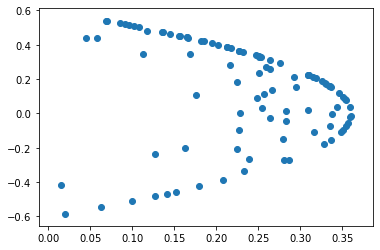

In [99]:
data = np.array(record)
plt.scatter(data[:,1]**2 + data[:,2]**2, data[:,3])